## Learning average SR

In [32]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: Learning N agents on different games

### DQN agent class

In [33]:
class DQNActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DQNAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()

        self.returns = []
        
        self.replay = config.replay_fn()
        self.actor = DQNActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.loss_vec = []

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:
#             self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
            
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, done])
        self.replay.feed_batch(experiences)

        if self.total_steps > self.config.exploration_steps:
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)
            q_next = self.target_network(next_states).detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1)[0]
            terminals = tensor(terminals)
            rewards = tensor(rewards)
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)
            actions = tensor(actions).long()
            q = self.network(states)
            q = q[self.batch_indices, actions]
            loss = (q_next - q).pow(2).mul(0.5).mean()
            self.loss_vec.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### DSR agent class

In [10]:
import torch.nn as nn

class Psi2QNet(nn.Module):
    def __init__(self, feature_dim):
        super(Psi2QNet, self).__init__()
        self.w = Parameter(torch.Tensor(feature_dim))
        nn.init.constant_(self.w, 0) # CHECK for better initialization
    
    def forward(self, psi):
        return torch.matmul(psi, self.w)

class SRNet_backup(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(256, 256), gate=F.relu):
        super(SRNet_backup, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        dims = (body.feature_dim,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.psi2q = Psi2QNet(body.feature_dim)

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = self.psi2q(psi)

        return phi, psi, out
    

#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

"""
DQN code modified to convert it to DSR by Surya.
The representations are not learned in this network.

"""


class DSRActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            _, psi, q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DSRAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []
        self.returns = []

        self.replay = config.replay_fn()
        self.actor = DSRActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.w_optimizer = config.optimizer_fn(self.network.psi2q.parameters()) # only on w's

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:

            # Reporting training progress on stdout
            # self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
                    
            self.total_steps += 1
            reward = config.reward_normalizer(reward)

            # Putting these new entries in experiences
            experiences.append([state, action, reward, next_state, done])

        # Add experiences to replay
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Sampling from replay buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences

            # Normalizing stat values
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1) # predicts max q values (vector of b) and corresponding arguments
                a_star = q_next[1]
                q_next = q_next[0]
                psi_next = psi_next[self.batch_indices, a_star, :]

            terminals = tensor(terminals)
            rewards = tensor(rewards)

            # Estimate q target
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)

            # Estimate psi target (obtained from target n/w) # CHECK: should we get target from network instead?
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # Adding the prediction for present state.

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = config.c * (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_q + loss_psi
            
            # Storing loss estimates
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            if(not np.isfinite(loss.item())):
                print(' loss has diverged!')
                import pdb;pdb.set_trace()
                return 
            
            self.optimizer.zero_grad()
            loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()
            
#             # Update all except w
#             self.optimizer.zero_grad()
#             loss_psi.backward(retain_graph=True)
#             nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
#             with config.lock:
#                 self.optimizer.step()
                
#             # Update w parameters
#             self.w_optimizer.zero_grad()
#             loss_q.backward()
#             nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
#             with config.lock:
#                 self.w_optimizer.step()
                
            

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### Sub function for DQN and DSR

In [11]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.00025)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(0.1, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent
    
# DQN
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
#             agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
    return agent

### Sanity checks

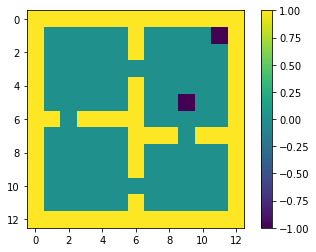

In [15]:
from deep_rl.component.fourrooms import FourRooms
env = FourRooms(goal=9)
state = env.reset()
plt.imshow(env.render())
plt.colorbar()

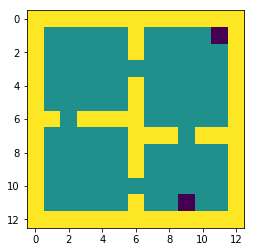

In [22]:
env.step(1)
plt.imshow(env.render())

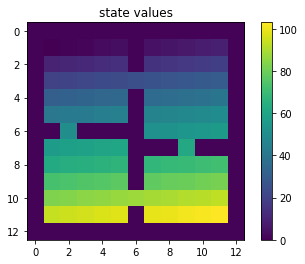

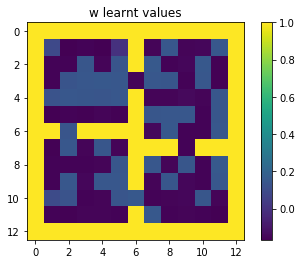

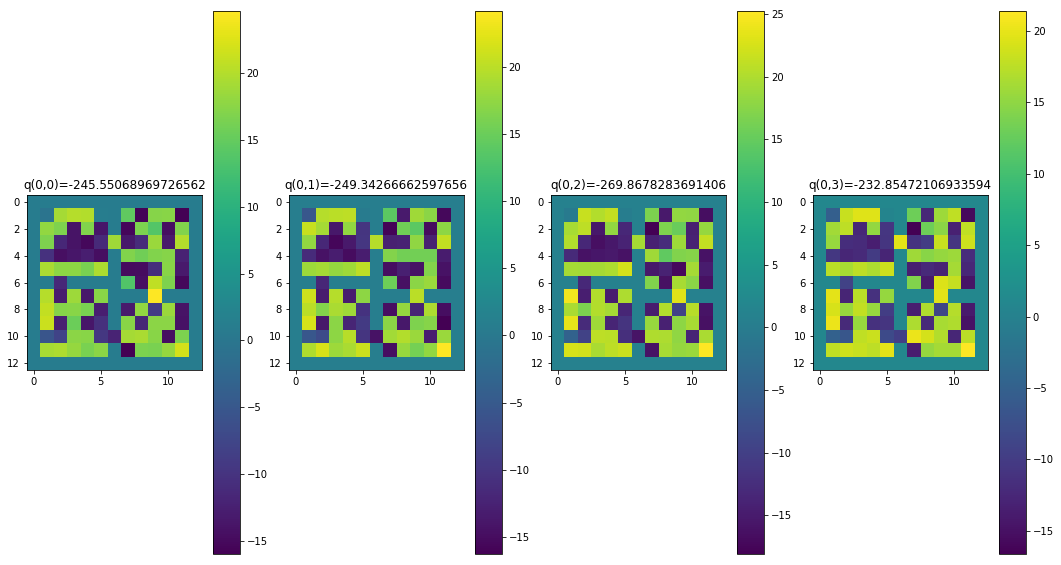

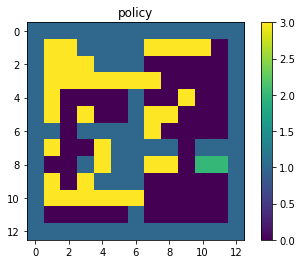

In [31]:
def _visualize_vector(vector, title="unnamed", show_goal=False, show=True):
    """Function to visualize vector of size 104"""
    
    current_grid = np.array(env.occupancy, dtype=np.float) # 1 - walls, 0 - 
    for i in range(104):
    #     if(vals[i]>0):
    #         import pdb; pdb.set_trace()
        p_cell = env.tocell[i]
        current_grid[p_cell[0], p_cell[1]] = vector[i]

        if show_goal:
            goal_cell = env.tocell[env.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -1
        
    plt.imshow(current_grid), plt.colorbar()
    plt.title(title)
    if show:
        plt.show()
    
def sanity(agent):
    # Setting things up
    env = FourRooms(goal=9)
    
    # Visualize state values
    statevals = list(range(104))
    _visualize_vector(statevals, title="state values")
    
    # Visualize w
    w_vector = agent.network.state_dict()['psi2q.w'].numpy()
    _visualize_vector(w_vector, title="w learnt values")
    
    # Visualize psi
    states = [0]
    plt.figure(figsize=(len(states)*18, 10))
    
    for i, s in enumerate(states):
        temp = np.zeros(len(env.obs_space))
        temp[s] = 26
        phi, psi, q = agent.network(tensor(temp).unsqueeze(0))
        psi = psi.detach().numpy()
        q = q.detach().numpy().flatten()
        for na in range(4):
            plt.subplot(len(states), 4, i*4+na+1)
            _visualize_vector(psi[:,na,:].flatten(), title="q({},{})={}".format(s, na, q[na]), show=False)
            
    plt.show()
    # Visualize policy
    state_space = np.identity(104)
    phi, psi, q = agent2.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    _visualize_vector(optimal_actions, title='policy')
    
    
    
    plt.show()
sanity(agent2)
    

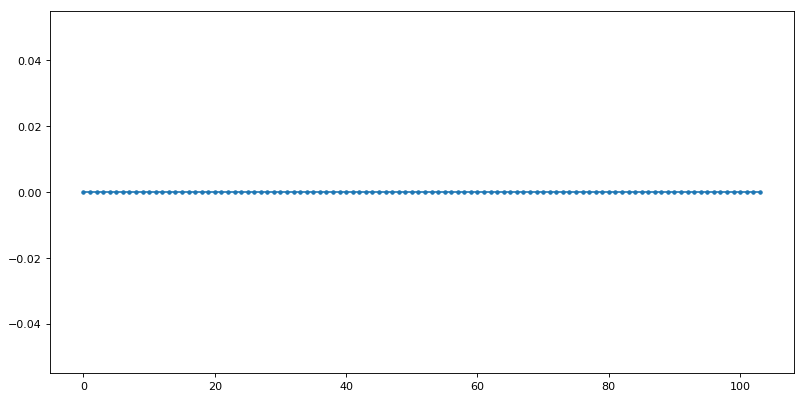

In [43]:
plt.figure(figsize=(12,6), dpi=80)
plt.plot(agent_k.network.state_dict()['w'].numpy(), '.-')

In [56]:
state = np.zeros(len(env.obs_space))
state[0] = 1
phi, psi, q = agent_k.network(tensor(state).unsqueeze(0))

In [57]:
psi.shape

torch.Size([1, 4, 104])

In [58]:
vals = psi[0,3,:].detach().numpy()
vals.shape
print(vals)

[0.         0.         0.         0.         0.         0.
 0.46973604 0.         0.58117604 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0035972  0.         0.03303562 0.
 0.         0.47290805 0.         0.42520842 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.39764488 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [106]:
vals = agent2.network.state_dict()['w'].numpy()

(<matplotlib.image.AxesImage at 0x7f9085183748>,
 <matplotlib.colorbar.Colorbar at 0x7f90851b5160>)

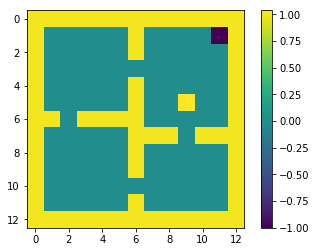

In [93]:
current_grid = np.array(env.occupancy, dtype=np.float) # 1 - walls, 0 - 
for i in range(104):
#     if(vals[i]>0):
#         import pdb; pdb.set_trace()
    p_cell = env.tocell[i]
    current_grid[p_cell[0], p_cell[1]] = vals[i]

    if True:
        goal_cell = env.tocell[env.goal]
        current_grid[goal_cell[0], goal_cell[1]] = -1
        
plt.imshow(current_grid), plt.colorbar()

In [ ]:
len(storage[0][0][1])

3219
3425
3471
3314
3451
3407
3368
3300
3545
3555


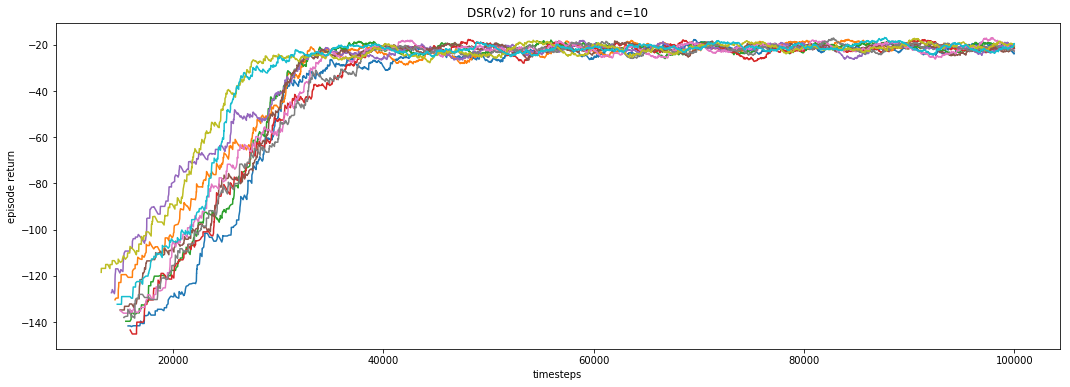

In [12]:
plt.figure(figsize=(18,6))
for i, s in enumerate(storage):
#     if(i < 9):
#         continue
    returns = s[0]
    print(len(returns))
    plt.plot(np.array(returns)[110:,0],convolve(np.array(returns)[:,1], kernelSize=111)/111)

plt.title('DSR(v2) for 10 runs and c=10')
plt.ylabel('episode return'), plt.xlabel('timesteps')
plt.show()

### Functions

In [6]:
### Plotting the results
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize), 'valid')
    return array

def plot_dqn(obj, title = 'DQN'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(311)
    plt.plot(convolve(obj.loss_vec, kernelSize=11)/11)
    plt.title(title+' loss on 4rooms')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(312)
    plt.plot(convolve(obj.loss_vec, kernelSize=111)/111)
    plt.title(title+' smoothed loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(313)
    plt.plot(np.array(obj.returns)[:,0],np.array(obj.returns)[:,1])
    plt.xlabel('timesteps'), plt.ylabel('return')
    plt.title('DQN training performance 4rooms')
    plt.show()

def plot_dsr(obj, title='DSR'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(211)
    plt.plot(convolve(obj.loss_q_vec, kernelSize=11)/11)
    plt.title(title+' loss on 4rooms')
    plt.ylabel('loss q value'), plt.xlabel('batch no')
    plt.subplot(212)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss on 4rooms')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')

### Code: Running N agents

In [7]:
mkdir('log')
mkdir('tf_log')
set_one_thread()
random_seed()
select_device(-1)

In [12]:
runs = 1
storage = []
for run in range(runs):
    agent2 = dsr_feature(game='FourRooms-Goal-9')
    storage.append([agent2.returns, agent2.loss_vec, agent2.loss_q_vec, agent2.loss_psi_vec])

2020-04-15 20:30:34,037 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-15 20:30:43,314 - root - INFO: steps 5000, episodic_return_test -180.30(18.69)
2020-04-15 20:30:52,521 - root - INFO: steps 10000, episodic_return_test -121.80(30.29)
2020-04-15 20:31:01,855 - root - INFO: steps 15000, episodic_return_test -121.90(30.25)
2020-04-15 20:31:11,176 - root - INFO: steps 20000, episodic_return_test -25.90(18.36)
2020-04-15 20:31:21,622 - root - INFO: steps 25000, episodic_return_test -180.40(18.59)
2020-04-15 20:31:32,237 - root - INFO: steps 30000, episodic_return_test -8.40(1.18)
2020-04-15 20:31:41,935 - root - INFO: steps 35000, episodic_return_test -6.00(0.86)
2020-04-15 20:31:51,972 - root - INFO: steps 40000, episodic_return_test -47.80(24.12)
2020-04-15 20:32:01,832 - root - INFO: steps 45000, episodic_return_test -12.00(1.61)
2020-04-15 20:32:11,812 - root - INFO: steps 50000, episodic_return_test -6.90(1.10)


In [13]:
print(agent2.network)

SRNet_backup(
  (body): SRIdentityBody()
  (layers): ModuleList(
    (0): Linear(in_features=104, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=416, bias=True)
  )
  (psi2q): Psi2QNet()
)


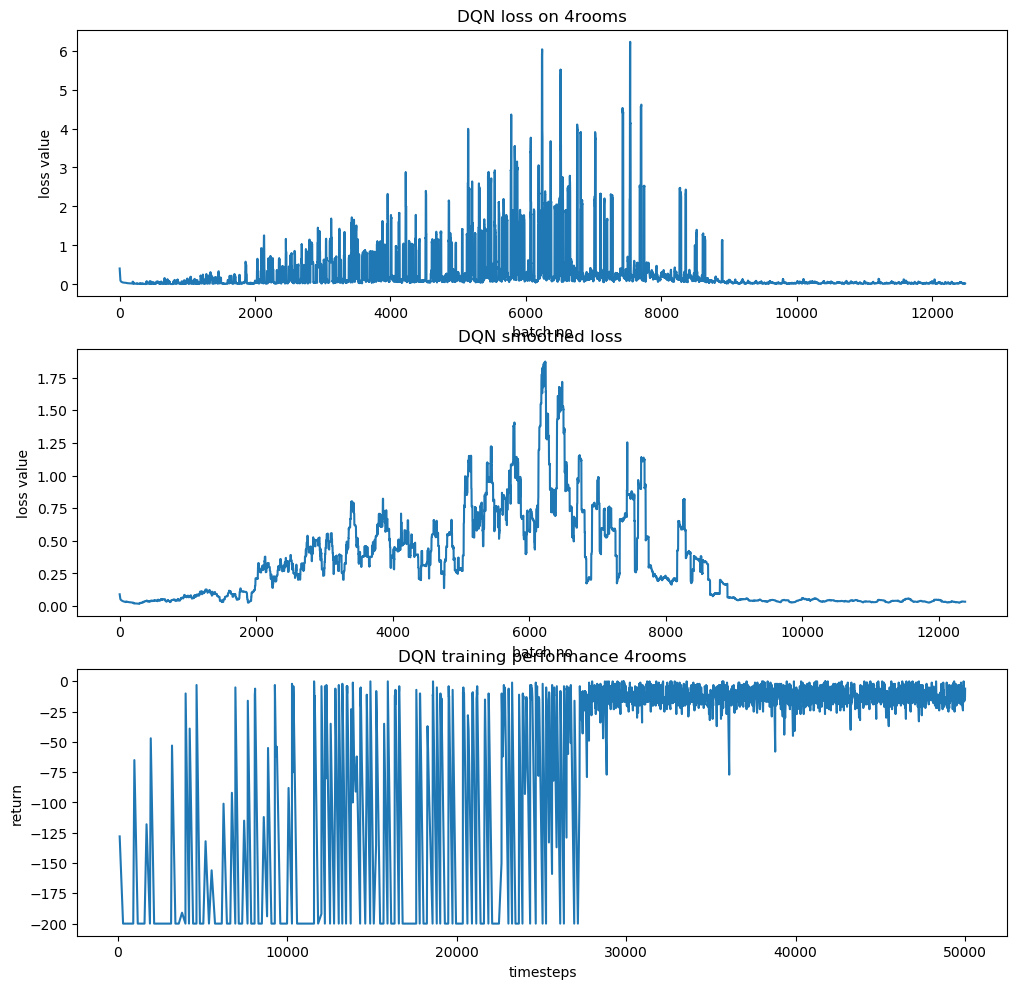

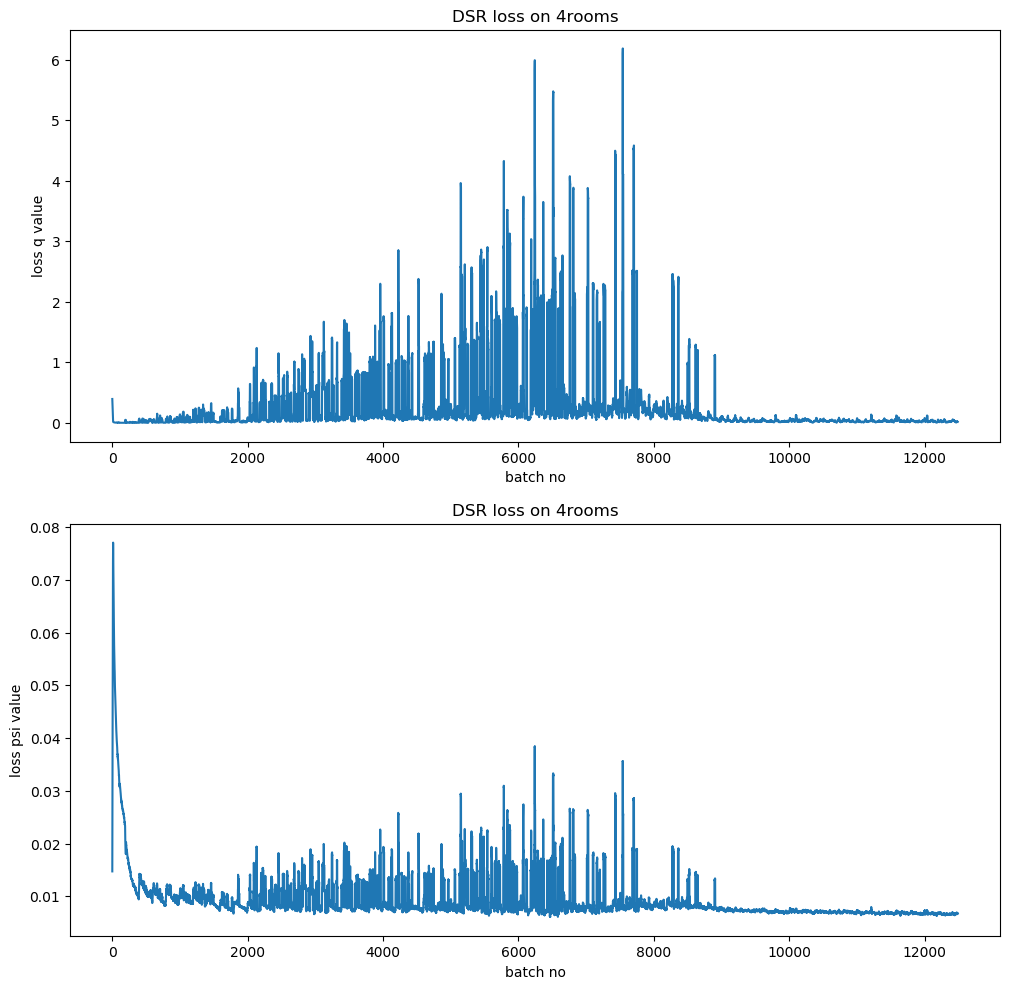

In [14]:
plot_dqn(agent2)
plot_dsr(agent2)

In [18]:
from random import randrange
agents = []
runs = 3
for i in range(runs):
    goal = randrange(100)
    print(i, goal)
    agents.append(dqn_feature(game='FourRooms-Goal-'+str(goal)))

0 40


2020-04-11 13:47:54,640 - root - INFO: steps 0, episodic_return_test -180.20(18.78)
2020-04-11 13:47:59,277 - root - INFO: steps 5000, episodic_return_test -120.50(30.79)
2020-04-11 13:48:03,716 - root - INFO: steps 10000, episodic_return_test -64.20(28.13)
2020-04-11 13:48:08,611 - root - INFO: steps 15000, episodic_return_test -102.30(30.91)
2020-04-11 13:48:13,484 - root - INFO: steps 20000, episodic_return_test -10.00(1.59)
2020-04-11 13:48:17,401 - root - INFO: steps 25000, episodic_return_test -26.20(18.40)
2020-04-11 13:48:21,324 - root - INFO: steps 30000, episodic_return_test -6.30(1.43)
2020-04-11 13:48:25,289 - root - INFO: steps 35000, episodic_return_test -7.20(1.33)
2020-04-11 13:48:29,278 - root - INFO: steps 40000, episodic_return_test -9.00(1.69)
2020-04-11 13:48:33,785 - root - INFO: steps 45000, episodic_return_test -25.20(18.46)
2020-04-11 13:48:37,969 - root - INFO: steps 50000, episodic_return_test -8.30(1.53)


1 58


2020-04-11 13:48:38,449 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-11 13:48:42,862 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-04-11 13:48:47,026 - root - INFO: steps 10000, episodic_return_test -180.30(18.69)
2020-04-11 13:48:51,197 - root - INFO: steps 15000, episodic_return_test -180.50(18.50)
2020-04-11 13:48:55,156 - root - INFO: steps 20000, episodic_return_test -82.10(30.45)
2020-04-11 13:48:58,998 - root - INFO: steps 25000, episodic_return_test -6.80(1.33)
2020-04-11 13:49:02,875 - root - INFO: steps 30000, episodic_return_test -6.30(1.32)
2020-04-11 13:49:07,189 - root - INFO: steps 35000, episodic_return_test -8.60(0.99)
2020-04-11 13:49:11,250 - root - INFO: steps 40000, episodic_return_test -8.70(1.14)
2020-04-11 13:49:15,745 - root - INFO: steps 45000, episodic_return_test -6.20(1.19)
2020-04-11 13:49:20,146 - root - INFO: steps 50000, episodic_return_test -6.50(1.25)


2 15


2020-04-11 13:49:20,777 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-11 13:49:25,683 - root - INFO: steps 5000, episodic_return_test -140.90(28.55)
2020-04-11 13:49:30,392 - root - INFO: steps 10000, episodic_return_test -102.20(30.93)
2020-04-11 13:49:34,702 - root - INFO: steps 15000, episodic_return_test -24.70(18.49)
2020-04-11 13:49:39,731 - root - INFO: steps 20000, episodic_return_test -8.10(1.14)
2020-04-11 13:49:47,285 - root - INFO: steps 25000, episodic_return_test -6.80(1.00)
2020-04-11 13:49:51,515 - root - INFO: steps 30000, episodic_return_test -5.80(1.26)
2020-04-11 13:49:55,719 - root - INFO: steps 35000, episodic_return_test -5.90(1.24)
2020-04-11 13:50:00,063 - root - INFO: steps 40000, episodic_return_test -7.70(1.54)
2020-04-11 13:50:04,332 - root - INFO: steps 45000, episodic_return_test -6.40(1.26)
2020-04-11 13:50:08,595 - root - INFO: steps 50000, episodic_return_test -6.10(1.10)


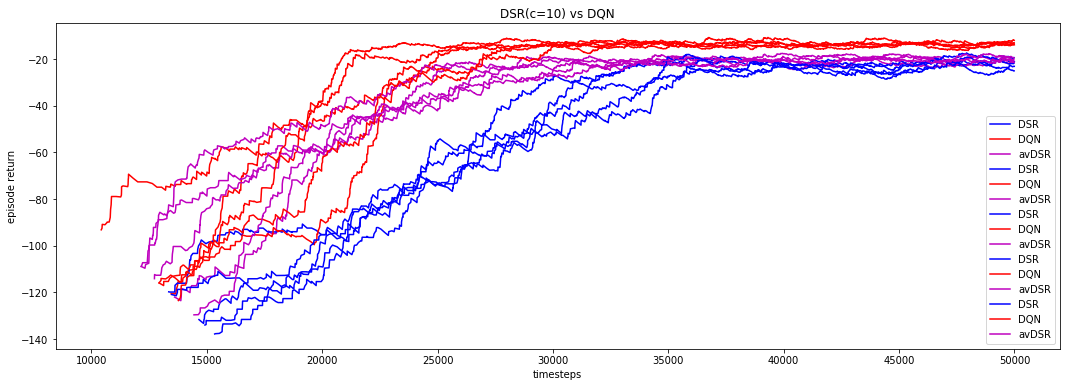

In [30]:
plt.figure(figsize=(18,6))
for i, s in enumerate(storage):
#     if(i < 9):
#         continue
    returns = s[0]
    plt.plot(np.array(returns)[110:,0],convolve(np.array(returns)[:,1], kernelSize=111)/111, 'b', label='DSR')
    plt.plot(np.array(agents[i].returns)[110:,0],convolve(np.array(agents[i].returns)[:,1], kernelSize=111)/111, 'r', label='DQN')
    plt.plot(r_vec[i][110:],convolve(np.array(t_vec[i]), kernelSize=111)/111, 'm', label='avDSR')
    
plt.title('DSR(c=10) vs DQN')
plt.ylabel('episode return'), plt.xlabel('timesteps')
plt.legend()
plt.show()

## Part 2: Learning an average SR agent (unsupervised)

### Class definition for average agent

In [35]:
a.network.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[ 0.4081,  0.5838, -0.3029, -0.0026, -0.4627,  0.7357,  0.3237],
                      [-0.2101,  0.9520, -0.1714,  0.3028,  0.7811, -0.1698, -0.2563],
                      [ 0.2409, -0.2902, -0.2155,  0.9198,  0.4713, -0.7781,  0.0746],
                      [ 0.2384,  0.7460,  1.1512, -0.1569, -0.1745, -0.4568,  0.2185],
                      [-0.3111,  0.1013,  0.7770,  0.3832, -0.4767,  0.0546, -0.5473],
                      [ 0.7393, -0.3331,  0.3999, -0.3161,  0.5118,  0.0311, -0.6389],
                      [-0.1762,  0.5693, -0.5343, -0.4019, -0.4760, -0.3123, -0.2618]])),
             ('layers.0.bias',
              tensor([0.2016, 0.1654, 0.2136, 0.4178, 0.3760, 0.4077, 0.2096])),
             ('layers.1.weight',
              tensor([[ 0.3724, -0.3802, -0.1019, -0.6220, -0.6260,  0.2695,  0.4679],
                      [-1.0556,  0.3006,  0.2757,  0.1663,  0.4992,  1.0601, -0.1114],
                      [ 0.3360, -0.6

In [29]:
# a = dqn_feature(game='FourRooms-Goal-9')
# a = dqn_feature(game='LineWorld')
a = dsr_feature(game='LineWorld')

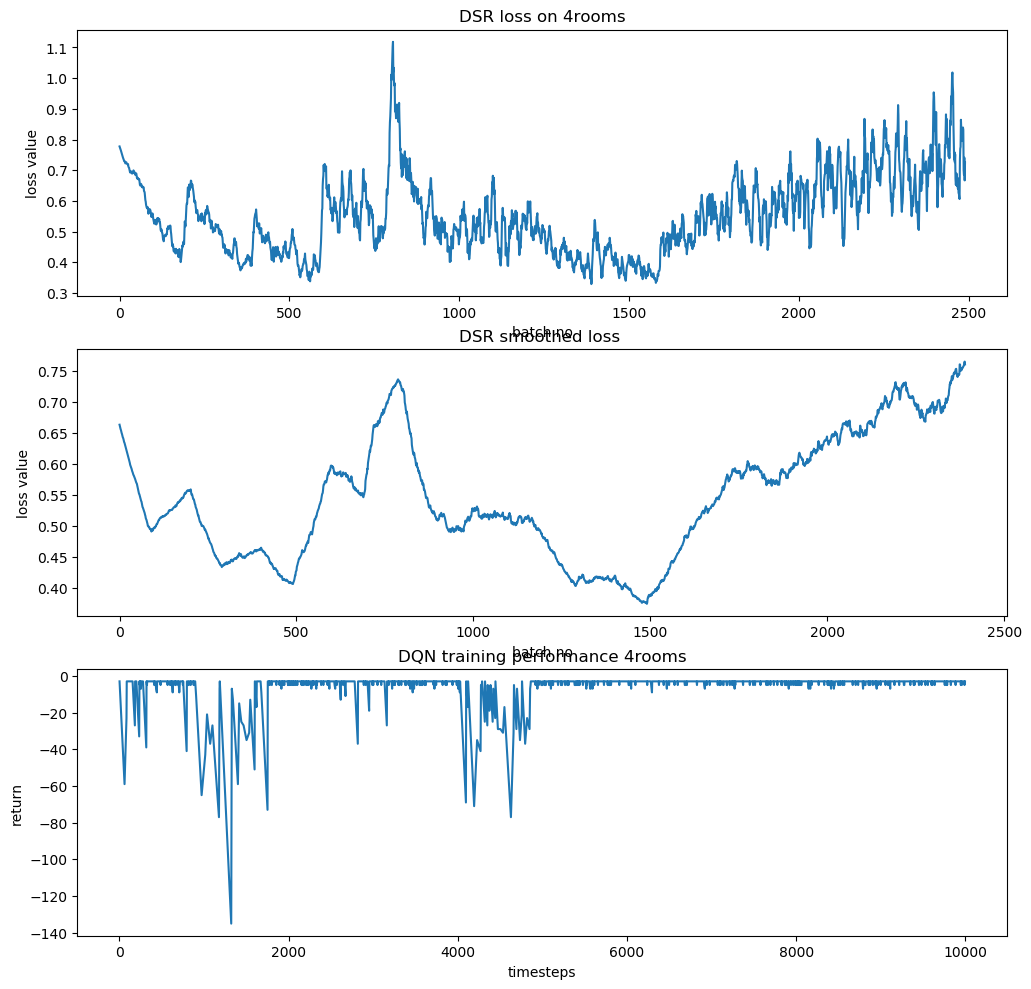

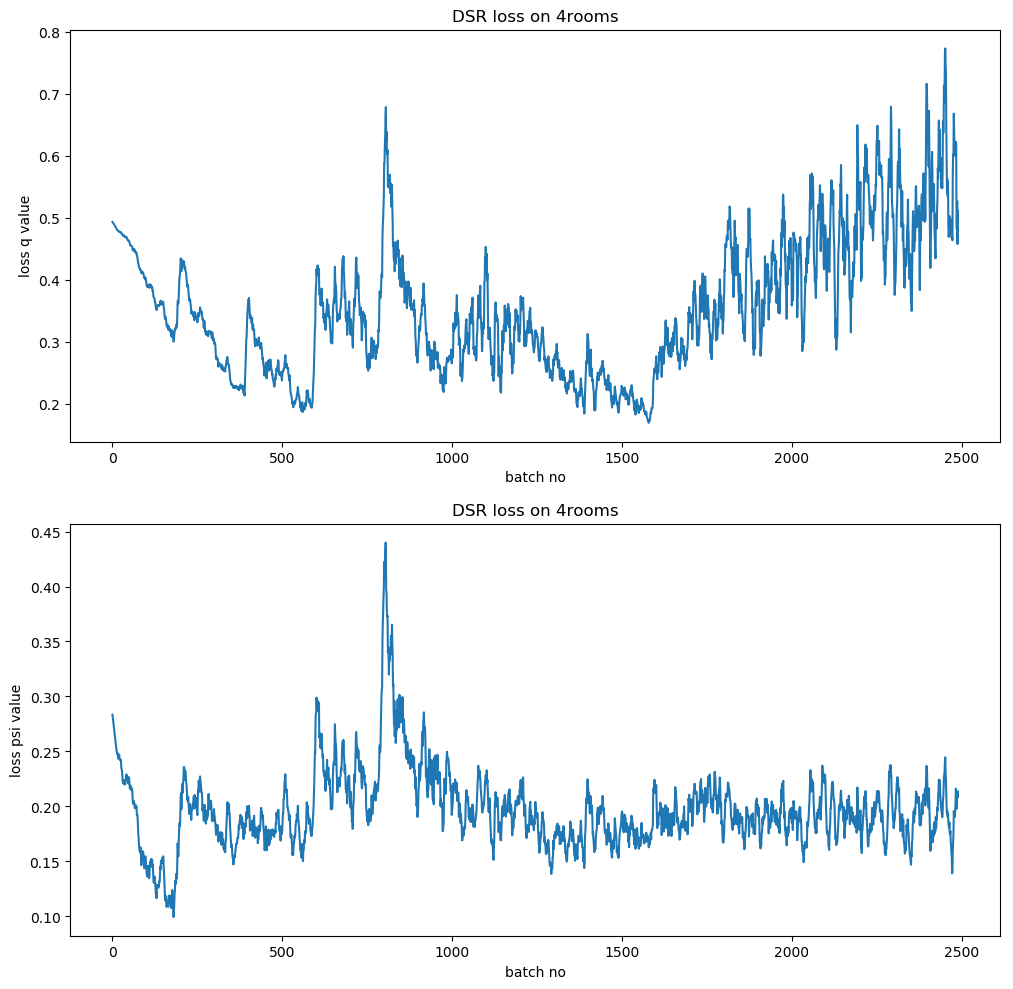

In [30]:
plot_dqn(a, title='DSR')
plot_dsr(a)

In [8]:
import random
"""
Code for learning the averageSR agent across good policies.
"""


class avDSRActor(BaseActor):
    def __init__(self, config, agents):
        BaseActor.__init__(self, config)
        self.config = config
        self.agents = agents
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config

        # Choose one of the base agents randomly
        pick = random.choice(self.agents)

        # Find qvalues of the picked agent for the present state
        with config.lock:
            q_values = pick.network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()

        # Take action based on this estimated q value
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
            
        next_state, reward, done, info = self._task.step([action])
        
        # Also estimate next action
        #############
        pick2 = random.choice(self.agents)
        with config.lock:
            q_values = pick2.network(config.state_normalizer(next_state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            next_action = np.random.randint(0, len(q_values))
        else:
            next_action = np.argmax(q_values)
        
        entry = [self._state[0], action, reward[0], next_state[0], next_action, int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class avDSRAgent(BaseAgent):
    def __init__(self, config, agents):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.actor = avDSRActor(config, agents)

        self.network = config.network_fn()
        self.network.share_memory()
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size) # Need to make this size bigger

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:
#             self.record_online_return(info)
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Getting samples from buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Estimate targets
            _, psi_next, _ = self.network(next_states)
            psi_next = psi_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.network(states)[0]) # TODO: double chec this

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, _ = self.network(states)
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
#             import pdb; pdb.set_trace()
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean(0)
            loss = loss_psi
            
            total_loss = loss.mean()
            self.loss_vec.append(total_loss.item())
            self.loss_psi_vec.append(total_loss.item())
            
            
            self.optimizer.zero_grad()
            loss.backward(torch.ones(loss.shape))
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()


### Coding: avDSR

In [64]:
def avDSR(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.00025)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e6), batch_size=10)

    config.random_action_prob = LinearSchedule(0.0, 0.0, 1e6) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e3
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

### Code to learn average agent

In [65]:
agent_k = avDSR(game='FourRooms-Goal-9', agents=[a])

2020-04-12 07:37:59,911 - root - INFO: steps 0, 83886080.00 steps/s
2020-04-12 07:38:02,443 - root - INFO: steps 1000, 395.48 steps/s


In [66]:
def plot_dsr(obj, title='DSR'):
    plt.figure(figsize=(12,6),dpi=100)
#     plt.subplot(211)
#     plt.plot(convolve(obj.loss_q_vec, kernelSize=11)/11)
#     plt.title(title+' loss on 4rooms')
#     plt.ylabel('loss q value'), plt.xlabel('batch no')
#     plt.subplot(212)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=111)/111)
    plt.title(title+' loss on 4rooms')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')

In [67]:
agent_k.network

SRNet_backup(
  (body): SRIdentityBody()
  (layers): ModuleList(
    (0): Linear(in_features=104, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=416, bias=True)
  )
  (layer1): Linear(in_features=104, out_features=104, bias=True)
  (layer2): Linear(in_features=104, out_features=104, bias=True)
  (layer3): Linear(in_features=104, out_features=416, bias=True)
)

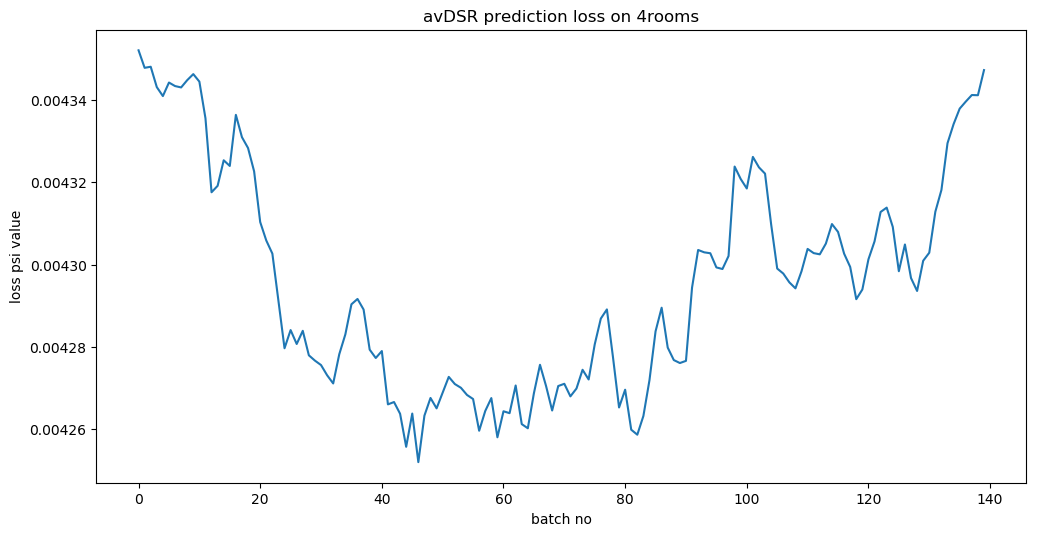

In [68]:
plot_dsr(agent_k, 'avDSR prediction')

In [67]:
agent_k.network.state_dict()# ensure w has only 0s. 

OrderedDict([('w',
              tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0.])),
             ('layers.0.weight',
              tensor([[ 0.0278, -0.1014,  0.1235,  ..., -0.1057, -0.0281,  0.0239],
                      [-0.0242, -0.0089,  0.0841,  ..., -0.0322,  0.1025,  0.0850],
                      [-0.0577, -0.0331,  0.0385,  ..., -0.0491, -0.0707,  0.0505],
                      ...,
                      [-0.0009,  0.0115,  0.0601,  ..., -0.0943, -0.1045,  0.0492],
                      [ 0.0461, -0.0844, -0.0612,  ..., 

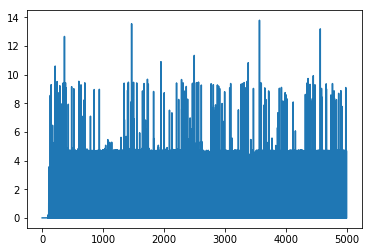

In [68]:
plt.plot(agent_k.loss_vec)

## Part 3: Learning agent initialized to avSR across good policies

In [23]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 10

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

In [25]:
r_vec = []; t_vec = []

from tqdm import trange, tqdm
for i in trange(5, desc='runs'): 
    agent_f = dsr_feature_init(ref=agent_k, game='FourRooms-Goal-9')
    rewards = np.array(agent_f.returns)
    r_vec.append(rewards[:,0])
    t_vec.append(rewards[:,1])
    

runs:   0%|          | 0/5 [00:00<?, ?it/s]2020-04-10 01:14:30,390 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-10 01:14:38,464 - root - INFO: steps 5000, episodic_return_test -160.90(24.73)
2020-04-10 01:14:46,567 - root - INFO: steps 10000, episodic_return_test -121.00(30.60)
2020-04-10 01:14:54,784 - root - INFO: steps 15000, episodic_return_test -122.40(30.07)
2020-04-10 01:15:03,287 - root - INFO: steps 20000, episodic_return_test -106.50(29.62)
2020-04-10 01:15:11,287 - root - INFO: steps 25000, episodic_return_test -90.60(28.58)
2020-04-10 01:15:19,647 - root - INFO: steps 30000, episodic_return_test -31.60(17.85)
2020-04-10 01:15:28,075 - root - INFO: steps 35000, episodic_return_test -28.80(18.13)
2020-04-10 01:15:36,852 - root - INFO: steps 40000, episodic_return_test -69.80(27.10)
2020-04-10 01:15:45,767 - root - INFO: steps 45000, episodic_return_test -33.30(17.82)
2020-04-10 01:15:54,828 - root - INFO: steps 50000, episodic_return_test -48.70(23.98)
r

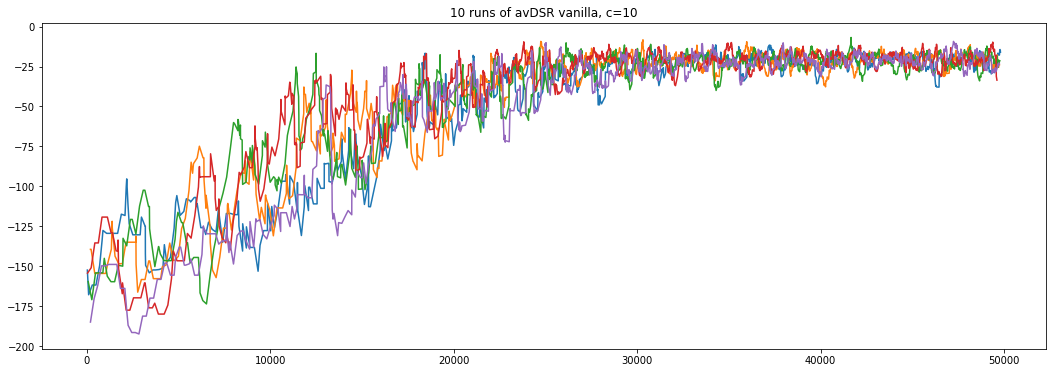

In [26]:
plt.figure(figsize=(18, 6))
for t, r in zip(r_vec, t_vec):
    plt.plot(t[:-10], convolve(r, kernelSize=11)/11)
    plt.title('10 runs of avDSR vanilla, c=' + str(agent_f.config.c))

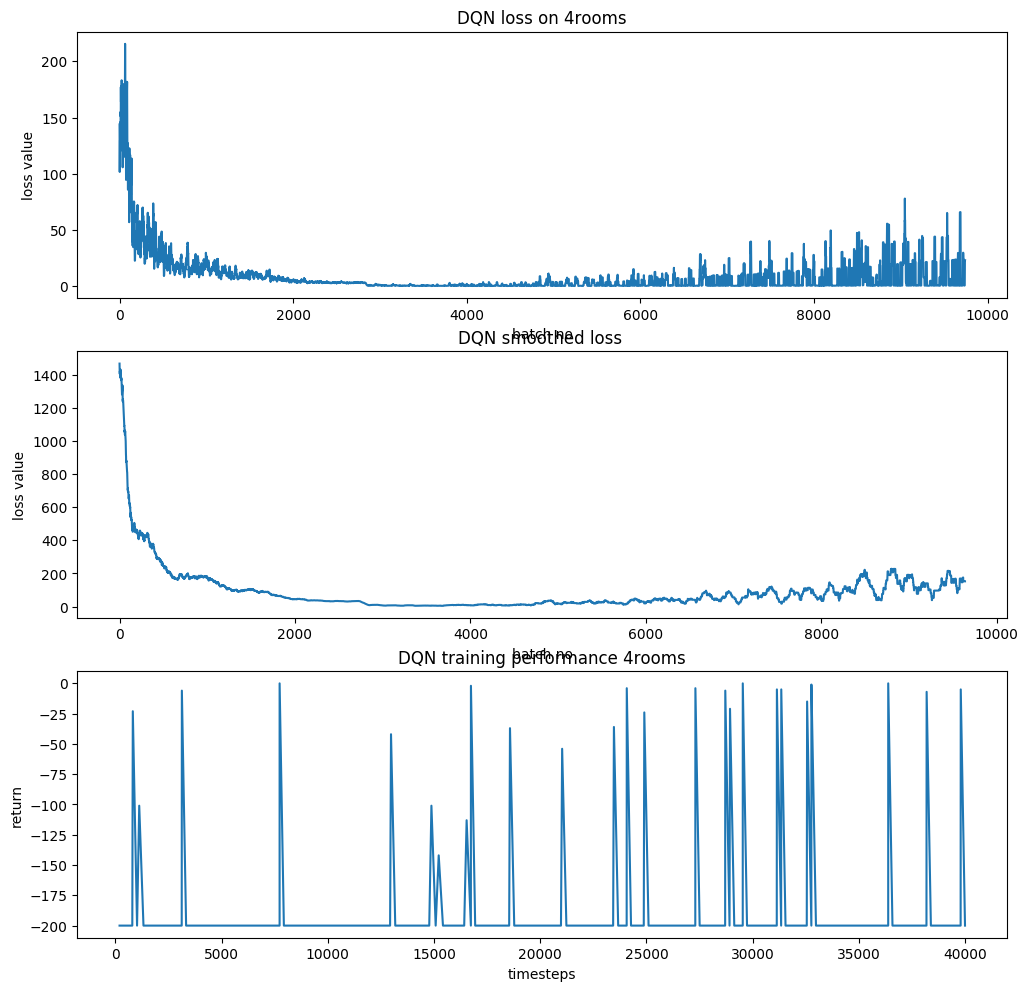

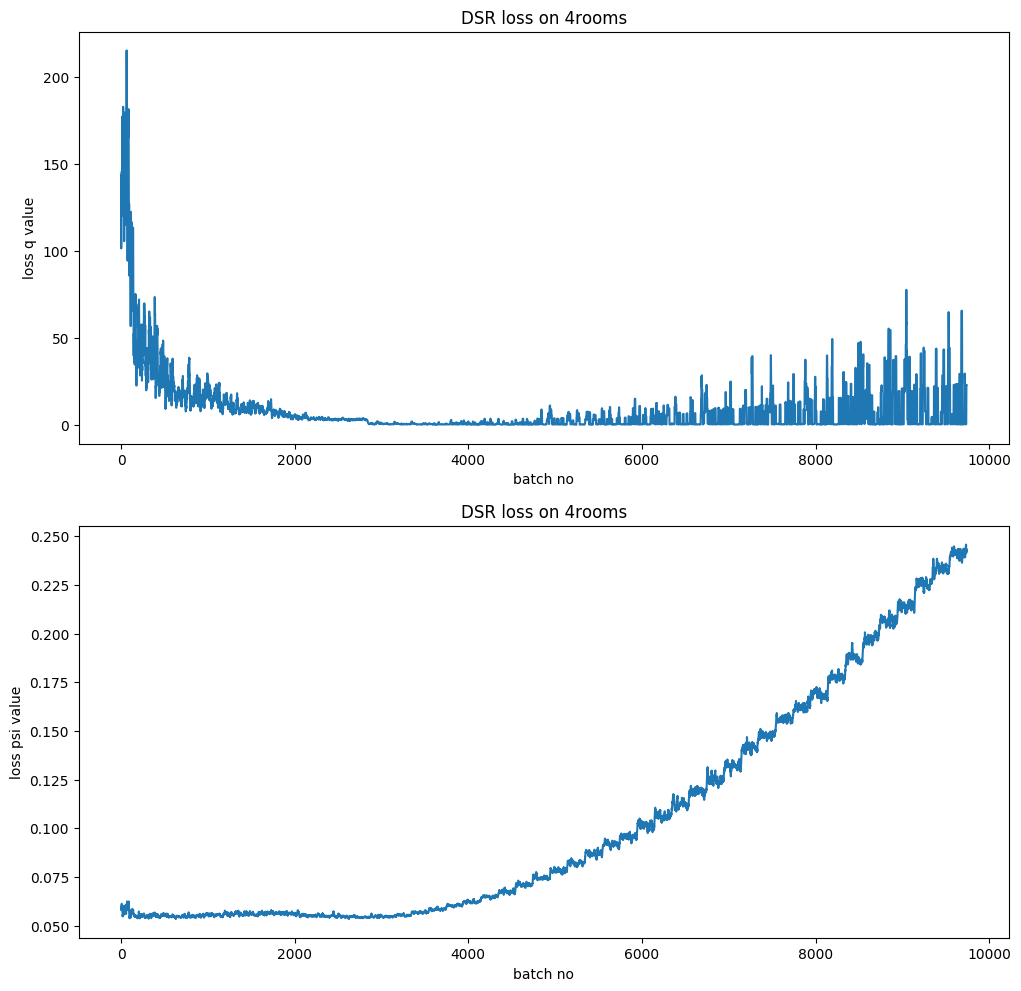

In [124]:
plot_dqn(agent_f)
plot_dsr(agent_f)

In [34]:
dqn_feature(game='FourRooms-Goal-94')

2020-04-03 04:00:22,424 - root - INFO: steps 0, episodic_return_test -162.30(23.88)
2020-04-03 04:00:26,184 - root - INFO: steps 5000, episodic_return_test -160.00(25.30)
2020-04-03 04:00:30,259 - root - INFO: steps 10000, episodic_return_test -142.20(27.93)
2020-04-03 04:00:34,276 - root - INFO: steps 15000, episodic_return_test -160.80(24.80)
2020-04-03 04:00:38,102 - root - INFO: steps 20000, episodic_return_test -50.50(23.72)
2020-04-03 04:00:42,004 - root - INFO: steps 25000, episodic_return_test -36.30(17.31)
2020-04-03 04:00:45,626 - root - INFO: steps 30000, episodic_return_test -14.70(2.79)
2020-04-03 04:00:49,692 - root - INFO: steps 35000, episodic_return_test -14.00(1.54)
2020-04-03 04:00:53,780 - root - INFO: steps 40000, episodic_return_test -13.30(3.19)
2020-04-03 04:00:57,819 - root - INFO: steps 45000, episodic_return_test -14.50(2.68)
2020-04-03 04:01:01,727 - root - INFO: steps 50000, episodic_return_test -18.20(3.36)
2020-04-03 04:01:05,546 - root - INFO: steps 5500

Process AsyncReplay-21:
Traceback (most recent call last):
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/network/home/penmetss/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [35]:
test = dqn_feature(game='FourRooms-Goal-103')

2020-04-03 04:01:45,473 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-03 04:01:48,924 - root - INFO: steps 5000, episodic_return_test -180.20(18.78)
2020-04-03 04:01:52,922 - root - INFO: steps 10000, episodic_return_test -160.80(24.80)
2020-04-03 04:01:57,036 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-04-03 04:02:00,927 - root - INFO: steps 20000, episodic_return_test -102.50(30.87)
2020-04-03 04:02:04,710 - root - INFO: steps 25000, episodic_return_test -104.80(30.13)
2020-04-03 04:02:08,313 - root - INFO: steps 30000, episodic_return_test -90.70(28.28)
2020-04-03 04:02:12,061 - root - INFO: steps 35000, episodic_return_test -14.20(1.44)
2020-04-03 04:02:15,726 - root - INFO: steps 40000, episodic_return_test -13.40(2.14)
2020-04-03 04:02:19,787 - root - INFO: steps 45000, episodic_return_test -18.40(3.12)
2020-04-03 04:02:23,529 - root - INFO: steps 50000, episodic_return_test -15.70(2.10)
2020-04-03 04:02:27,246 - root - INFO: steps 550

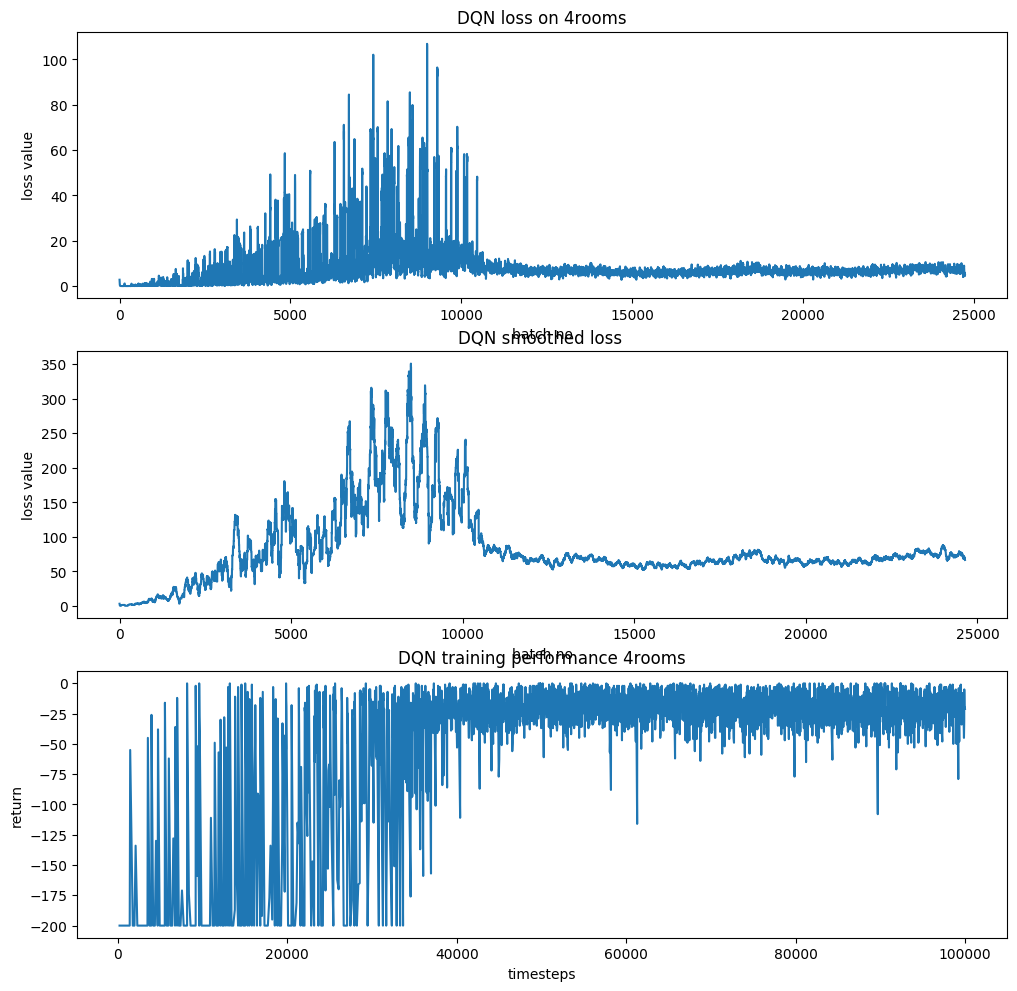

In [37]:
plot_dqn(test)